In [1]:
import tensorflow as tf 
import os
from glob import glob
import numpy as np
import pydicom
from PIL import Image, ImageDraw
import json
import matplotlib.pyplot as plt
import cv2

# Let's download PeenFudanPed Dataset

In [2]:
! wget https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip .
! unzip PennFudanPed.zip

--2021-01-31 07:29:35--  https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip
Resolving www.cis.upenn.edu (www.cis.upenn.edu)... 158.130.69.163, 2607:f470:8:64:5ea5::d
Connecting to www.cis.upenn.edu (www.cis.upenn.edu)|158.130.69.163|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 53723336 (51M) [application/zip]
Saving to: 'PennFudanPed.zip'

PennFudanPed.zip    100%[===================>]  51.23M  4.26MB/s    in 18s     

2021-01-31 07:29:54 (2.91 MB/s) - 'PennFudanPed.zip' saved [53723336/53723336]

--2021-01-31 07:29:54--  http://./
Resolving . (.)... failed: No address associated with hostname.
wget: unable to resolve host address '.'
FINISHED --2021-01-31 07:29:54--
Total wall clock time: 18s
Downloaded: 1 files, 51M in 18s (2.91 MB/s)
Archive:  PennFudanPed.zip
   creating: PennFudanPed/
  inflating: PennFudanPed/added-object-list.txt  
   creating: PennFudanPed/Annotation/
  inflating: PennFudanPed/Annotation/FudanPed00001.txt  
  inflating: PennF

# Check dataset and make file path list

In [3]:
data_root_dir = 'PennFudanPed/'
img_dir = os.path.join(data_root_dir, 'PNGImages')
mask_dir = os.path.join(data_root_dir, 'PedMasks')

img_path_list = glob(os.path.join(img_dir, '*.png'))
mask_path_list = glob(os.path.join(mask_dir, '*.png'))

print("Total Image Number: ",len(img_path_list))
print("Total Mask Number: ",len(mask_path_list))

replaced = [s.replace('PNGImages', 'PedMasks').replace('.png', '_mask.png') for s in img_path_list]

mask_yes = [s for s in replaced if s in mask_path_list]
mask_no = [s for s in replaced if s not in mask_path_list]

complete_mask_list = sorted(mask_yes)
complete_img_list = sorted([s.replace('PedMasks', 'PNGImages').replace('_mask.png', '.png') for s in complete_mask_list])

print("Let's use only images with binary")
print(len(complete_img_list), len(complete_mask_list))

Total Image Number:  170
Total Mask Number:  170
Let's use only images with binary
170 170


In [4]:
complete_img_list[0]

'PennFudanPed/PNGImages/FudanPed00001.png'

In [5]:
complete_mask_list[0]

'PennFudanPed/PedMasks/FudanPed00001_mask.png'

In [6]:
def list_order_check(img_list, mask_list):
    for img_path, mask_path in zip(img_list, mask_list):
        img_id = img_path.split('PNGImages/')[1].split('.png')[0]
        mask_id = mask_path.split('PedMasks/')[1].split('_mask.png')[0]

        assert (img_id == mask_id)

    print('No Problem')

In [7]:
list_order_check(complete_img_list, complete_mask_list)

No Problem


# Plot some images and masks of dataset, and check masks pixel values

np.unique(mask_array): [0 1 2]


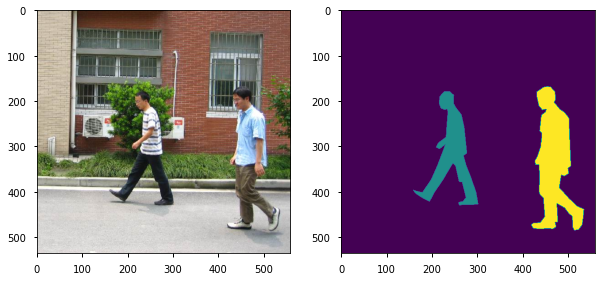

np.unique(mask_array): [0 1]


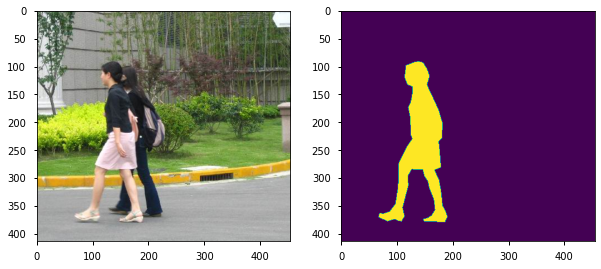

np.unique(mask_array): [0 1]


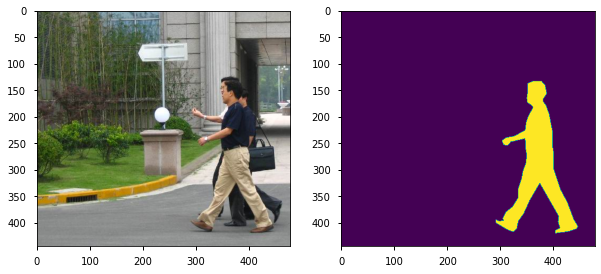

np.unique(mask_array): [0 1 2]


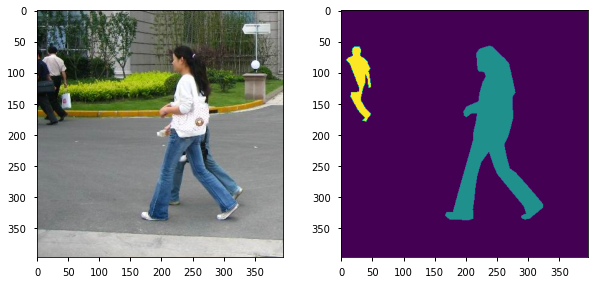

np.unique(mask_array): [0 1 2]


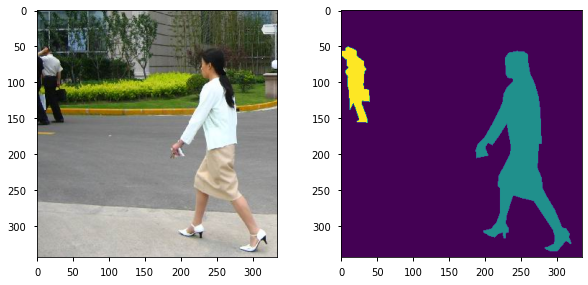

np.unique(mask_array): [0 1 2]


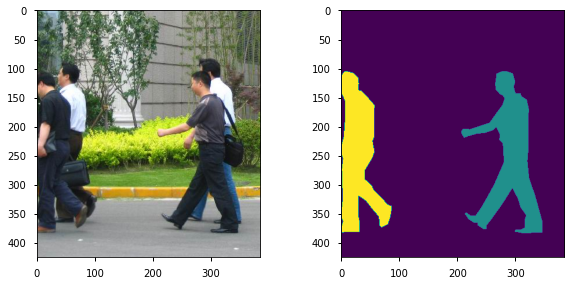

In [8]:
for idx, (img_path, mask_path) in enumerate(zip(complete_img_list, complete_mask_list)):
    plt.style.use(['seaborn-notebook'])
    fig = plt.figure(figsize=(10, 10))
    
    img = Image.open(img_path)
    mask = Image.open(mask_path)
    
    img_array = np.array(img)
    mask_array = np.array(mask)
    
    print(f'np.unique(mask_array): {np.unique(mask_array)}')
    ax1 = fig.add_subplot(2, 2, 1)
    ax2 = fig.add_subplot(2, 2, 2)
    
    ax1.imshow(img_array)
    ax2.imshow(mask_array)
    plt.show()
    
    if idx >= 5:
        break

In [9]:
mask_array.shape

(426, 385)

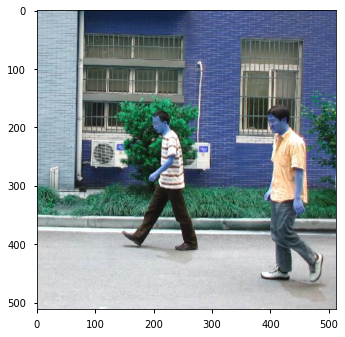

In [10]:
img = cv2.imread('PennFudanPed/PNGImages/FudanPed00001.png')
resized_img = cv2.resize(img, dsize=(512, 512), interpolation=cv2.INTER_CUBIC)
plt.imshow(resized_img)

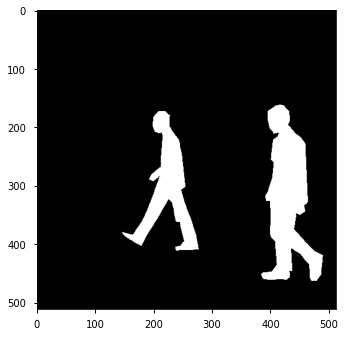

In [11]:
mask = cv2.imread('PennFudanPed/PedMasks/FudanPed00001_mask.png')
resized_mask = cv2.resize(mask, dsize=(512, 512), interpolation=cv2.INTER_CUBIC)
plt.imshow(np.where(resized_mask > 0.5, 255, 0))

In [116]:
type(mask)

numpy.ndarray

In [113]:
mask.shape

(406, 612, 3)

In [114]:
resized_mask.shape

(512, 512, 3)

# Let's segment just human or not

So, I will make masks' all pixel values for human 1

In [12]:
# The following functions can be used to convert a value to a type compatible
# with tf.train.Example.

def _bytes_feature(value):
    """Returns a bytes_list from a string / byte."""
    if isinstance(value, type(tf.constant(0))):
        value = value.numpy() # BytesList won't unpack a string from an EagerTensor.
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _float_feature(value):
    """Returns a float_list from a float / double."""
    return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))

def _int64_feature(value):
    """Returns an int64_list from a bool / enum / int / uint."""
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value])) 

In [13]:
def make_image_mask_train_example(img_path, mask_path, height, width):
    img = np.asarray(Image.open(img_path), dtype=np.float32)
    mask = np.asarray(Image.open(mask_path), dtype=np.float32)
    
    mask = np.where(mask > 0.5, 1, 0).astype(np.float32)  # Target: human or not
    
    resized_img = cv2.resize(img, dsize=(height, width), interpolation=cv2.INTER_CUBIC)
    resized_mask = cv2.resize(mask, dsize=(height, width), interpolation=cv2.INTER_CUBIC)

    img_array = resized_img.astype(np.float32).reshape(height, width, 3)
    mask_array = np.where(resized_mask >= 0.5, 1, 0).astype(np.float32).reshape(height, width, 1)

    feature = {
        "img": _bytes_feature(img_array.tobytes()),
        "mask": _bytes_feature(mask_array.tobytes()),
        'h': _int64_feature(height),
        'w': _int64_feature(width)
    }

    return tf.train.Example(features=tf.train.Features(feature=feature)) 

In [14]:
def write_path_list_to_tfrecord(
    img_path_list,
    mask_path_list,
    record_file_name
):
    
    with tf.io.TFRecordWriter(record_file_name) as writer:
        for img_path, mask_path in zip(img_path_list, mask_path_list):
            image_example = make_image_mask_train_example(img_path, mask_path, 512, 512)
            writer.write(image_example.SerializeToString())

In [15]:
def make_disease_tfrecord(
    complete_img_list, complete_mask_list,
    tfrecords_dir='tf_records',
    valid_proportion=0.3
):

    # Find dcm file paths corresponding to disease
    png_img_path_list = []
    png_mask_path_list = []

    for img_path, mask_path in zip(complete_img_list, complete_mask_list):
        png_img_path_list.append(img_path)
        png_mask_path_list.append(mask_path)

    print(f'Total size of dataset: {len(png_img_path_list)}')

    print(f'Checking list order of png lists...')
    list_order_check(png_img_path_list, png_mask_path_list)
    print()

    # Train - Valid Split
    N = len(png_img_path_list)
    valid_size = int(N * valid_proportion)
    train_size = N - valid_size

    print(f'train size: {train_size}')
    print(f'valid size: {valid_size}')

    train_img_path_list = png_img_path_list[0:train_size]
    valid_img_path_list = png_img_path_list[train_size:]

    train_mask_path_list = png_mask_path_list[0:train_size]
    valid_mask_path_list = png_mask_path_list[train_size:]

    print(f'\nChecking list order of train lists...')
    list_order_check(train_img_path_list, train_mask_path_list)

    print(f'\nChecking list order of valid lists...')
    list_order_check(valid_img_path_list, valid_mask_path_list)
    print()

    train_record_name = os.path.join(tfrecords_dir, f'train.tfrecords')
    valid_record_name = os.path.join(tfrecords_dir, f'valid.tfrecords')

    write_path_list_to_tfrecord(train_img_path_list, train_mask_path_list, train_record_name)
    write_path_list_to_tfrecord(valid_img_path_list, valid_mask_path_list, valid_record_name) 

In [16]:
make_disease_tfrecord(
    complete_img_list=complete_img_list,
    complete_mask_list=complete_mask_list,
    tfrecords_dir='tf_records',
    valid_proportion=0.4
)

Total size of dataset: 170
Checking list order of png lists...
No Problem

train size: 102
valid size: 68

Checking list order of train lists...
No Problem

Checking list order of valid lists...
No Problem



# Usage Example

In [17]:
import tensorflow as tf 
import matplotlib.pyplot as plt
import os
import numpy as np

raw_image_dataset = tf.data.TFRecordDataset(os.path.join('tf_records', 'train.tfrecords'))

# Create a dictionary describing the features.
image_feature_description = {
    'img': tf.io.FixedLenFeature([], tf.string),
    'mask': tf.io.FixedLenFeature([], tf.string),
    'h': tf.io.FixedLenFeature([], tf.int64),
    'w': tf.io.FixedLenFeature([], tf.int64)
}

def _parse_image_function(example_proto):
  # Parse the input tf.train.Example proto using the dictionary above.
  return tf.io.parse_single_example(example_proto, image_feature_description)

parsed_image_dataset = raw_image_dataset.map(_parse_image_function)
parsed_image_dataset

<MapDataset shapes: {h: (), img: (), mask: (), w: ()}, types: {h: tf.int64, img: tf.string, mask: tf.string, w: tf.int64}>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tf.Tensor(512, shape=(), dtype=int64)
tf.Tensor(512, shape=(), dtype=int64)
(262144,)


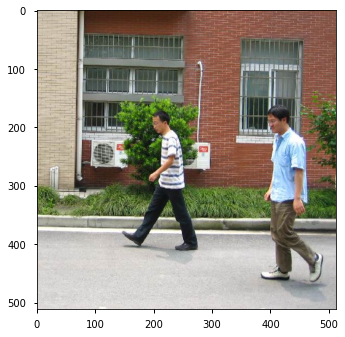

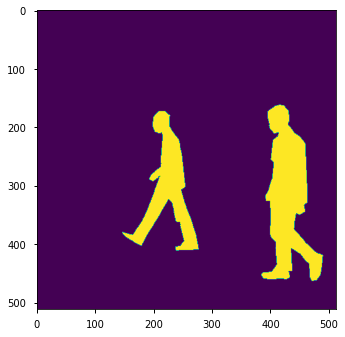

In [18]:
for image_features in parsed_image_dataset.take(1):
    img = np.frombuffer(image_features['img'].numpy(), dtype=np.float32)
    mask = np.frombuffer(image_features['mask'].numpy(), dtype=np.float32)
    h = image_features['h']
    w = image_features['w']
    print(h)
    print(w)
    print(mask.shape)
    
    fig,ax = plt.subplots(1)
    ax.imshow(img.reshape(h, w, 3) / 255)
    plt.show()
    
    fig,ax = plt.subplots(1)
    ax.imshow(mask.reshape(h, w))
    plt.show() 

In [19]:
img.reshape(h, w, 3).shape

(512, 512, 3)

In [20]:
mask.reshape(h, w).shape

(512, 512)